### Dependencias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import warnings
import os

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score

from scipy import stats
from varclushi import VarClusHi
from functools import reduce
from dateutil.relativedelta import relativedelta as rd

warnings.filterwarnings('ignore')
cf.go_offline()

### Lectura de Datos

In [2]:
ruta = '/home/guadalupe/analisis/Datos/full_history'

* La función np.random.choice() permite elegir aleatoriamente un subconjunto de un conjunto de datos.

In [3]:
# De la ruta elegimos 20 archivos aleatorios sin reemplazo.
muestra = np.random.choice(os.listdir(ruta), 20, replace=False)
muestra

array(['FWONA.csv', 'GBF.csv', 'OCC.csv', 'NXC.csv', 'TCRD.csv',
       'BSAC.csv', 'CHH.csv', 'SCL.csv', 'QQQX.csv', 'GAZ.csv',
       'ABCB.csv', 'AGGP.csv', 'SBOW.csv', 'ATRC.csv', 'AIRTW.csv',
       'BLX.csv', 'CEVA.csv', 'FONR.csv', 'SBS.csv', 'MFUS.csv'],
      dtype='<U11')

* Con os.path.join() se puede unir el nombre de un directorio con el nombre de un archivo. Ponemos la ruta del directorio y se concatena con el nombre del archivo al final (antecedido por un /).

In [4]:
# Ejemplo para el primer caso
ruta_1 = os.path.join(ruta, muestra[0])
ruta_1

'/home/guadalupe/analisis/Datos/full_history/FWONA.csv'

In [5]:
def leerArchivo(arch):
    # Leemos el archivo (para ello completamos la ruta) con las columnas que necesitamos
    df = pd.read_csv(os.path.join(ruta,arch),usecols=['date','open','close','high','low'])
    # Extraemos el nombre del archivo (acción)
    nombre = arch.split('.')[0]
    # Convertimos la fecha a formato datetime
    df['date'] = pd.to_datetime(df['date']).dt.date
    # Creamos una columna con el nombre de la acción
    df.insert(1,'accion',nombre)
    return df    

In [6]:
# Aplicamos la función a todos los archivos de la muestra y concatenamos los resultados en un solo dataframe.
df = pd.concat(map(leerArchivo,muestra),ignore_index=True)

In [7]:
df.shape

(79990, 6)

### Ingenieria de Características

In [8]:
# Ventana de observación (Vamos a observar los datos de los últimos 15 días)
vobs = 15
# Ventana de desplazamiento (Vamos a predecir los datos del siguiente día)
vdes = 1
step = 3

#### Inspección inicial

In [9]:
# La columna 'date' la convertimos a formato año-mes, contamos y ordenamos los valores.
df['date'].map(lambda x: x.strftime('%Y-%m')).value_counts().sort_index().iplot(
    # Graficamos
    kind='bar', title='Observaciones por mes', color='purple')

In [10]:
fchaf,fchai = df['date'].max(),df['date'].max()+rd(years=-1)
fchai,fchaf

(datetime.date(2019, 7, 2), datetime.date(2020, 7, 2))

In [11]:
# Tomamos las fechas que esten entre la fecha final y la fecha inicial
df = df[(df['date']>=fchai) & (df['date']<=fchaf)].reset_index(drop=True)
df.shape

(4280, 6)

In [12]:
# Nueva grafica considerando los datos de los últimos 12 meses (filtrados arriba)
df['date'].map(lambda x: x.strftime('%Y-%m')).value_counts().sort_index().iplot(
    kind='bar', title='Observaciones por mes', color='purple')

### Catálogo de fechas

In [13]:
# Creamos el dataframe con la columna 'date', quitamos los duplicados, ordenamos y reseteamos el indice.
catfcha = df[['date']].drop_duplicates().sort_values('date').reset_index(drop=True)
# Insertamos una columna al inicio con el nombre 'id' y los valores del indice+1
catfcha.insert(0,'id',catfcha.index+1)
# Unimos los dataframes y eliminamos la columna 'date'. SOLO LO USAMOS PARA ASIGNAR EL ID DE ACUERDO A LA FECHA.
df = df.merge(catfcha,on='date',how='inner').drop('date',axis=1)
df.head()

,accion,open,high,low,close,id
0,FWONA,32.730000,32.730000,30.850000,31.18,245
1,GBF,124.610001,124.739998,124.599998,124.68,245
2,OCC,2.710000,2.780000,2.650000,2.77,245
3,NXC,15.970000,16.170000,15.840000,16.10,245
4,BSAC,17.309999,17.309999,16.980000,17.17,245


In [14]:
anclai, anclaf = df['id'].min()+vobs-1, df['id'].max()-vdes
anclai, anclaf

(15, 253)

### Matriz de predicción $\mathcal{X}$

In [15]:
varc = ['open','close','high','low']
um = ['accion','ancla']

In [16]:
cruzar = lambda x,y: x.merge(y,on=um,how='outer')
apilar = lambda x,y: pd.concat([x,y],ignore_index=True)

In [17]:
def ingX(df,ancla,sub)->pd.DataFrame:
    aux = df[(df['id']<=ancla)&(df['id']>=(ancla-sub+1))].copy().reset_index(drop=True)
    funciones = [np.mean,np.median,np.std,np.min,np.max]
    nombresf = ['mean','mediana','std','min','max']
    l = []
    for v in varc:
        for nombre,func in zip(nombresf,funciones):
            nombre = f'x_{nombre}_{v}_{sub}'
            # Agrupa la función por acción y calcula la función
            agg = aux[['accion',v]].groupby('accion').agg(func).rename(columns={v:nombre}).reset_index()
            agg.insert(1,'ancla',ancla)
            l.append(agg)
    # Cruza los dataframes
    aux = reduce(cruzar,l)
    return aux

In [18]:
X =reduce(cruzar,map(lambda sub: reduce(apilar, map(lambda ancla: ingX(df, ancla, sub),
    range(anclai, anclaf+1))), range(step, vobs+step, step)))

In [19]:
X.head()

,accion,ancla,x_mean_open_3,x_mediana_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_mediana_close_3,x_std_close_3,...,x_mean_high_15,x_mediana_high_15,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_mediana_low_15,x_std_low_15,x_min_low_15,x_max_low_15
0,ABCB,15,37.559999,37.509998,0.180277,37.410000,37.759998,37.523333,37.490002,0.241729,...,38.798001,38.880001,0.811068,37.730000,40.340000,38.025333,38.299999,0.730771,37.040001,39.160000
1,AGGP,15,19.439334,19.448000,0.016773,19.420000,19.450001,19.410000,19.410000,0.010000,...,19.440933,19.440001,0.050256,19.370001,19.545000,19.401400,19.400000,0.050287,19.340000,19.520000
2,ATRC,15,31.443333,31.389999,0.293655,31.180000,31.760000,31.590000,31.670000,0.405956,...,31.792000,31.700001,0.349187,31.100000,32.360001,31.082000,31.120001,0.328812,30.430000,31.500000
3,BLX,15,21.090000,21.049999,0.301994,20.809999,21.410000,21.186666,21.049999,0.263122,...,20.965333,20.889999,0.385410,20.420000,21.990000,20.474667,20.469999,0.271605,19.910000,20.950001
4,BSAC,15,29.986667,30.040001,0.128582,29.840000,30.080000,29.786666,29.840000,0.293655,...,30.131333,30.160000,0.170037,29.809999,30.360001,29.788000,29.830000,0.183233,29.459999,30.030001


### Vector de respuesta $\vec{y}$

In [20]:
def ingY(df,ancla)->pd.DataFrame:
    aux = df[(df['id']>ancla)&(df['id']<=(ancla+vdes))].copy().reset_index(drop=True)[['accion','close']]
    aux = aux.rename(columns={'close':'y'})
    aux.insert(1,'ancla',ancla)
    return aux

In [21]:
y = reduce(apilar,map(lambda ancla : ingY(df,ancla),range(anclai,anclaf+1)))

In [22]:
y.head()

,accion,ancla,y
0,FWONA,15,36.880001
1,GBF,15,116.410004
2,OCC,15,3.940000
3,NXC,15,14.800000
4,BSAC,15,29.620001


In [23]:
# Unimos los dataframes
tad = X.merge(y,on=um,how='inner')
tad.head()

,accion,ancla,x_mean_open_3,x_mediana_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_mediana_close_3,x_std_close_3,...,x_mediana_high_15,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_mediana_low_15,x_std_low_15,x_min_low_15,x_max_low_15,y
0,ABCB,15,37.559999,37.509998,0.180277,37.410000,37.759998,37.523333,37.490002,0.241729,...,38.880001,0.811068,37.730000,40.340000,38.025333,38.299999,0.730771,37.040001,39.160000,38.570000
1,AGGP,15,19.439334,19.448000,0.016773,19.420000,19.450001,19.410000,19.410000,0.010000,...,19.440001,0.050256,19.370001,19.545000,19.401400,19.400000,0.050287,19.340000,19.520000,19.459999
2,ATRC,15,31.443333,31.389999,0.293655,31.180000,31.760000,31.590000,31.670000,0.405956,...,31.700001,0.349187,31.100000,32.360001,31.082000,31.120001,0.328812,30.430000,31.500000,32.520000
3,BLX,15,21.090000,21.049999,0.301994,20.809999,21.410000,21.186666,21.049999,0.263122,...,20.889999,0.385410,20.420000,21.990000,20.474667,20.469999,0.271605,19.910000,20.950001,21.490000
4,BSAC,15,29.986667,30.040001,0.128582,29.840000,30.080000,29.786666,29.840000,0.293655,...,30.160000,0.170037,29.809999,30.360001,29.788000,29.830000,0.183233,29.459999,30.030001,29.620001


In [28]:
# Guadamos el dataframe en un archivo parquet para usarlo después 
## Solo lo ejecutamos la primera vez, razón por la cual los datos son diferentes a los de arriba.##
tad.to_parquet('../Datos/tad_acciones_regresion.parquet')

In [24]:
tad = pd.read_parquet('../Datos/tad_acciones_regresion.parquet')
tad.shape

(4124, 103)

In [25]:
tad.head()

,accion,ancla,x_mean_open_3,x_mediana_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_mediana_close_3,x_std_close_3,...,x_mediana_high_15,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_mediana_low_15,x_std_low_15,x_min_low_15,x_max_low_15,y
0,AGRO,15,6.860000,6.840000,0.111355,6.760000,6.980000,6.890000,6.910000,0.091651,...,7.010000,0.087570,6.840000,7.170000,6.861333,6.890000,0.101056,6.620000,6.980000,6.860000
1,AQB,15,3.543333,3.540000,0.055076,3.490000,3.600000,3.430000,3.410000,0.170880,...,3.580000,0.248861,3.200000,4.080000,3.268067,3.180000,0.227707,3.001000,3.710000,3.420000
2,CSA,15,45.387000,45.395000,0.088274,45.294998,45.471001,45.320000,45.400002,0.174356,...,45.660000,0.235552,45.270000,46.070000,45.502533,45.439999,0.270733,45.119999,45.912998,46.369999
3,DD,15,71.696665,71.669998,0.046189,71.669998,71.750000,72.260000,71.970001,0.871951,...,72.209999,1.569930,69.800003,75.970001,71.206000,71.029999,1.409689,69.150002,74.449997,74.230003
4,DWMF,15,24.976667,24.959999,0.047258,24.940001,25.030001,24.976667,24.940001,0.081445,...,25.090000,0.109183,24.940001,25.389999,25.052667,25.040001,0.104572,24.860001,25.290001,25.070000


#### Partición de Datos

In [26]:
Sn, ot = [d.reset_index(drop=True) for _,d in tad.groupby(tad['ancla']>=217)]
Sn.shape,ot.shape

((3461, 103), (663, 103))

In [27]:
train,valid = train_test_split(Sn,test_size=0.3,random_state=123)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((2422, 103), (1039, 103))

### Análisis Exploratorio de Datos

In [36]:
um =['accion','ancla']
varc = [v for v in train.columns if v.startswith('x_')]
len(varc)

100

#### Ausentes

In [37]:
# Obtenemos el porcentaje de missing
miss = (train[varc].isnull().sum()/len(train)).to_frame().rename(columns={0:'pct_miss'})
# Ordenamos los valores
miss.sort_values(by = 'pct_miss',ascending = False, inplace = True)
miss

,pct_miss
x_std_high_3,0.003716
x_std_open_3,0.003716
x_std_close_3,0.003716
x_std_low_3,0.003716
x_std_close_6,0.000826
...,...
x_mediana_close_12,0.000000
x_std_close_12,0.000000
x_min_close_12,0.000000
x_max_close_12,0.000000


* Con la función SimpleImputer() de sklearn.impute se puede reemplazar los valores ausentes por la media, mediana o la moda.

In [38]:
# Reemplazamos los missing por la mediana
im = SimpleImputer(strategy='median')
# Ajustamos el imputer
im.fit(train[varc])

SimpleImputer(strategy='median')

* Con la función transform() se puede aplicar la transformación a los datos.

In [39]:
Xi = pd.DataFrame(im.transform(train[varc]),columns=varc)
Xi[um] = train[um]

In [40]:
Xi.head()

,x_mean_open_3,x_mediana_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_mediana_close_3,x_std_close_3,x_min_close_3,x_max_close_3,...,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_mediana_low_15,x_std_low_15,x_min_low_15,x_max_low_15,accion,ancla
0,0.726667,0.712,0.058398,0.677,0.791,0.745000,0.762,0.055489,0.683,0.79,...,0.103212,0.691,0.98,0.716133,0.67,0.069988,0.65,0.83,HNRG,210
1,4.090000,4.100,0.036055,4.050,4.120,4.116667,4.110,0.011547,4.110,4.13,...,0.624372,4.160,6.15,4.237333,3.99,0.513329,3.58,5.19,AGRO,187
2,13.196667,13.180,0.047258,13.160,13.250,13.095000,13.135,0.091788,12.990,13.16,...,0.225038,13.160,13.84,13.369667,13.49,0.212001,12.98,13.62,TWNK,79
3,0.270000,0.270,0.010000,0.260,0.280,0.260000,0.270,0.017321,0.240,0.27,...,0.087587,0.110,0.32,0.147333,0.11,0.064528,0.05,0.25,IBIO,113
4,1.513333,1.510,0.035119,1.480,1.550,1.490000,1.500,0.026457,1.460,1.51,...,0.050095,1.440,1.58,1.425333,1.42,0.043567,1.34,1.50,SYNC,60


* Con stats.ks_2samp() se puede realizar una prueba de Kolmogorov-Smirnov para comparar dos muestras.

In [42]:
# Creamos un dataframe
ks = pd.DataFrame( 
    # Aplicamos la prueba de Kolmogorov-Smirnov a las variables continuas
    map(lambda v: (v, stats.ks_2samp(Xi[v], train[v].dropna()).statistic), varc),
    # Renombramos las columnas y ordenamos por el estadístico de Kolmogorov-Smirnov
    columns=['var', 'ks']).sort_values(by='ks', ascending=False)

ks

,var,ks
7,x_std_close_3,0.001857
2,x_std_open_3,0.001857
17,x_std_low_3,0.001857
12,x_std_high_3,0.001857
37,x_std_low_6,0.000413
...,...,...
66,x_mediana_close_12,0.000000
67,x_std_close_12,0.000000
68,x_min_close_12,0.000000
69,x_max_close_12,0.000000


### Multicolinealidad

* La funcipon VarClusHi() se utiliza para realizar clustering jerárquico de variables. Se utiliza para detectar variables altamente correlacionadas.

In [44]:
vc = VarClusHi(df= Xi, feat_list=varc).varclus()

* Con sorted() se puede ordenar una lista, mientras que con sort() se puede ordenar una lista en el mismo objeto.

In [45]:
best = sorted(vc.rsquare.sort_values(by=['Cluster','RS_Ratio'],ascending=[1,1]).groupby('Cluster').first(
)['Variable'])
best

['x_mean_close_9', 'x_std_close_9']

### Extremos 

array([[<Axes: title={'center': 'x_mean_close_9'}>,
        <Axes: title={'center': 'x_std_close_9'}>]], dtype=object)

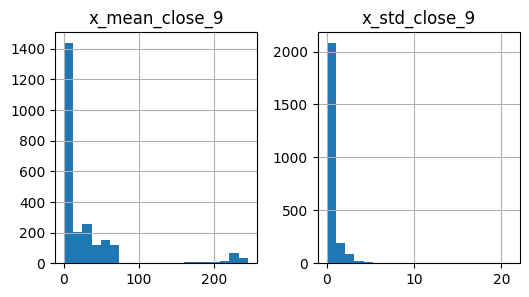

In [46]:
Xi[best].hist(figsize=(6,3),bins=20)

In [47]:
Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values

array([['x_mean_close_9', 0.23888888955116266, 236.25905704074432],
       ['x_std_close_9', 0.012658318174855035, 6.89265427189688]],
      dtype=object)

In [48]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = Xi[v].apply(lambda x: 1 if x<li or x>ls else 0)
    
Xi['ex_'] = Xi[[v for v in Xi.columns if v.startswith('ex_')]].max(axis=1)
Xi['ex_'].value_counts(1)

0    0.961602
1    0.038398
Name: ex_, dtype: float64

array([[<Axes: title={'center': 'x_mean_close_9'}>,
        <Axes: title={'center': 'x_std_close_9'}>]], dtype=object)

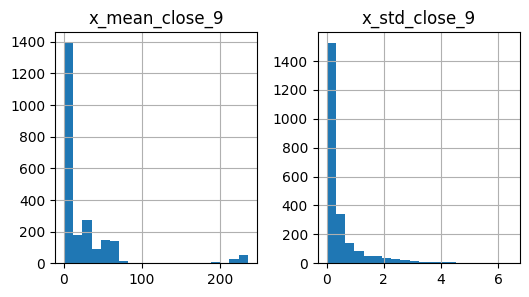

In [49]:
Xi[Xi['ex_']==0][best].hist(figsize=(6,3),bins=20)

In [50]:
Xi = Xi[Xi['ex_']==0].reset_index(drop=True)
Xi.drop([v for v in Xi.columns if v.startswith('ex_')],axis=1,inplace=True)
Xi

,x_mean_open_3,x_mediana_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_mediana_close_3,x_std_close_3,x_min_close_3,x_max_close_3,...,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_mediana_low_15,x_std_low_15,x_min_low_15,x_max_low_15,accion,ancla
0,0.726667,0.712000,0.058398,0.677000,0.791000,0.745000,0.762000,0.055489,0.683000,0.790000,...,0.103212,0.691000,0.980000,0.716133,0.670000,0.069988,0.650000,0.830000,HNRG,210
1,4.090000,4.100000,0.036055,4.050000,4.120000,4.116667,4.110000,0.011547,4.110000,4.130000,...,0.624372,4.160000,6.150000,4.237333,3.990000,0.513329,3.580000,5.190000,AGRO,187
2,13.196667,13.180000,0.047258,13.160000,13.250000,13.095000,13.135000,0.091788,12.990000,13.160000,...,0.225038,13.160000,13.840000,13.369667,13.490000,0.212001,12.980000,13.620000,TWNK,79
3,1.513333,1.510000,0.035119,1.480000,1.550000,1.490000,1.500000,0.026457,1.460000,1.510000,...,0.050095,1.440000,1.580000,1.425333,1.420000,0.043567,1.340000,1.500000,SYNC,60
4,42.776666,42.689999,0.634456,42.189999,43.450001,43.059334,43.319000,0.617876,42.354000,43.505001,...,2.488533,42.349998,48.879002,45.744600,46.709000,2.998409,40.320000,48.757999,CSA,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2.020000,2.010000,0.017320,2.010000,2.040000,2.026667,2.030000,0.015275,2.010000,2.040000,...,0.096287,2.020000,2.290000,2.071600,2.070000,0.062391,2.000000,2.200000,AQB,119
2325,2.481667,2.500000,0.040723,2.435000,2.510000,2.440000,2.450000,0.045826,2.390000,2.480000,...,0.077195,2.390000,2.650000,2.401600,2.400000,0.088092,2.260000,2.574000,AQB,81
2326,28.776667,28.770000,0.070238,28.709999,28.850000,28.893333,28.940001,0.098657,28.780001,28.959999,...,0.358087,28.090000,29.290001,28.187333,28.150000,0.370838,27.490000,28.730000,EQBK,94
2327,203.876668,203.050003,2.581269,201.809998,206.770004,204.923335,204.089996,4.597004,200.800003,209.880005,...,6.989144,188.440002,211.279999,196.562001,195.139999,6.860454,184.449997,206.300003,IJK,216


In [51]:
# Reemplazamos los missing por la mediana
im.fit(train[best])

SimpleImputer(strategy='median')

In [52]:
vart = ['y']

In [53]:
aux = Xi[um+best].merge(train[um+vart],on=um,how='inner')
Xt,yt = aux[um+best].copy(),aux[um+vart].copy()

### Aprendizaje

* Con el objeto Ridge() se puede crear un modelo de regresión lineal con regularización L2.

In [54]:
reg = Ridge()
# Entrenamos
reg.fit(Xt[best],yt[vart[0]])

Ridge()

In [55]:
# Obtenemos los coeficientes y el intercepto
reg.coef_, reg.intercept_

(array([ 1.00800963, -0.60446523]), 0.024271836515829648)

### Generalización

** Hacemos la evaluación del modelo con diferentes metrícas.**

In [56]:
pipe = make_pipeline(im,reg)
print({'train':mean_absolute_percentage_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_absolute_percentage_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_absolute_percentage_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 0.05705394146702389}
{'valid': 0.05490497736918314}
{'test': 0.059606094837509366}


In [57]:
print({'train':mean_absolute_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_absolute_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_absolute_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 0.585887805615798}
{'valid': 0.7141896773474656}
{'test': 0.8405422474647595}


In [58]:
print({'train':mean_squared_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_squared_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_squared_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 1.8404197535979938}
{'valid': 4.3313889698455394}
{'test': 4.4545463979514945}


In [59]:
print({'train':mean_squared_error(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':mean_squared_error(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':mean_squared_error(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 1.8404197535979938}
{'valid': 4.3313889698455394}
{'test': 4.4545463979514945}


In [60]:
print({'train':r2_score(y_pred=pipe.predict(Xt[best]),y_true=yt[vart[0]])})
print({'valid':r2_score(y_pred=pipe.predict(valid[best]),y_true=valid[vart[0]])})
print({'test':r2_score(y_pred=pipe.predict(ot[best]),y_true=ot[vart[0]])})

{'train': 0.9990764109933256}
{'valid': 0.998448438303395}
{'test': 0.9982519471355304}


In [63]:
valid['y^'] = pipe.predict(valid[best])
ot['y^'] = pipe.predict(ot[best])

In [65]:
ot.head()

,accion,ancla,x_mean_open_3,x_mediana_open_3,x_std_open_3,x_min_open_3,x_max_open_3,x_mean_close_3,x_mediana_close_3,x_std_close_3,...,x_std_high_15,x_min_high_15,x_max_high_15,x_mean_low_15,x_mediana_low_15,x_std_low_15,x_min_low_15,x_max_low_15,y,y^
0,AGRO,217,3.863333,3.910000,0.080829,3.770000,3.910000,3.843333,3.870000,0.064291,...,0.096575,3.910000,4.180000,3.839333,3.810000,0.135460,3.630000,4.060000,3.820000,3.880461
1,AQB,217,2.073333,2.070000,0.115036,1.960000,2.190000,2.146667,2.150000,0.115036,...,0.224462,1.720000,2.390000,1.760400,1.710000,0.140111,1.616000,2.070000,2.310000,1.843729
2,CSA,217,36.248667,36.404999,0.571760,35.615002,36.726002,36.323667,36.519001,0.844126,...,1.575483,33.109001,38.660000,35.341600,35.398998,1.511050,32.889999,37.764000,35.500000,35.927972
3,DD,217,45.276667,45.290001,0.810084,44.459999,46.080002,45.963333,46.200001,1.104190,...,2.869262,39.439999,49.130001,43.392000,44.360001,2.686815,38.279999,47.560001,45.680000,45.279476
4,DWMF,217,22.086667,22.139999,0.119303,21.950001,22.170000,22.139999,22.219999,0.211660,...,0.294832,21.490000,22.510000,21.798000,21.770000,0.310948,21.240000,22.410000,22.110001,21.972868


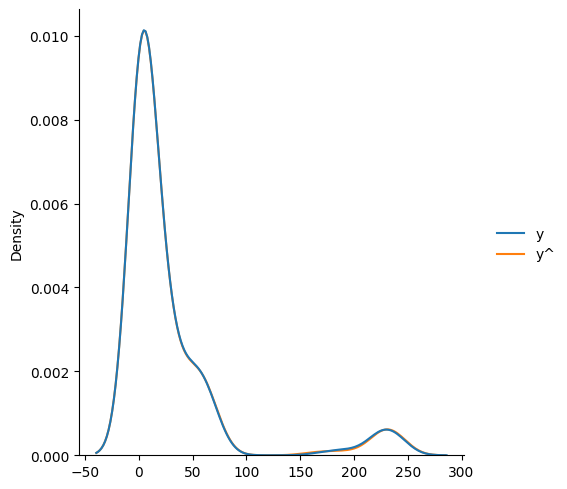

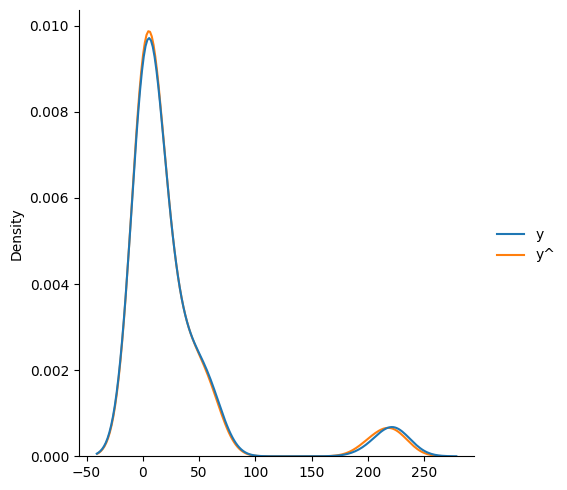

In [66]:
sns.displot(valid[vart+['y^']],kind='kde')
sns.displot(ot[vart+['y^']],kind='kde')

In [67]:
ot.sample(5)[['y^']+vart]

,y^,y
583,2.640232,2.56
572,11.978121,12.38
129,14.228157,15.51
526,3.487253,3.42
570,0.957905,1.12


In [68]:
best

['x_mean_close_9', 'x_std_close_9']